<a href="https://colab.research.google.com/github/VikasSingh-DS/Tensorflow-Gradient-Boosted-Trees/blob/master/Instacart%20Market%20Basket%20Analysis_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''Import modules.'''
import pandas as pd
import numpy as np

# Garbage Collector to free up memory
import gc                         
gc.enable()                       
import altair as alt # visualization

from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import clear_output

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
aisles_df = pd.read_csv("/content/drive/My Drive/instacart market basket analysis/aisles.csv")
departments_df = pd.read_csv("/content/drive/My Drive/instacart market basket analysis/departments.csv")
order_products_prior_df = pd.read_csv("/content/drive/My Drive/instacart market basket analysis/order_products__prior.csv")
order_products_train_df = pd.read_csv("/content/drive/My Drive/instacart market basket analysis/order_products__train.csv")
orders_df = pd.read_csv("/content/drive/My Drive/instacart market basket analysis/orders.csv")
products_df = pd.read_csv("/content/drive/My Drive/instacart market basket analysis/products.csv")
sample_submission = pd.read_csv("/content/drive/My Drive/instacart market basket analysis/sample_submission.csv")

DataFrames Description:

* **orders:** This table includes all orders, namely prior, train, and test. It has single primary key (order_id).
* **order_products_train:** This table includes training orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* **order_products_prior:** This table includes prior orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* **products:** This table includes all products. It has a single primary key (product_id)
* **aisles:** This table includes all aisles. It has a single primary key (aisle_id)
* **departments:** This table includes all departments. It has a single primary key (department_id)

In [0]:
aisles_df.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [0]:
departments_df.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [0]:
order_products_prior_df.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [0]:
order_products_train_df.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [0]:
orders_df.head()

order_id  user_id  ... order_hour_of_day  days_since_prior_order
0   2539329        1  ...                 8                     NaN
1   2398795        1  ...                 7                    15.0
2    473747        1  ...                12                    21.0
3   2254736        1  ...                 7                    29.0
4    431534        1  ...                15                    28.0

[5 rows x 7 columns]

In [0]:
orders_df['eval_set'].unique()

array(['prior', 'train', 'test'], dtype=object)

In [0]:
products_df.head()

product_id  ... department_id
0           1  ...            19
1           2  ...            13
2           3  ...             7
3           4  ...             1
4           5  ...            13

[5 rows x 4 columns]

Above data tables shows that, order.csv has all the imformation about the given order id ( the user who has purchased the order), order_number (no. of product puchased the user), when was it purchased, day since prior order and eval_set tells us as to which of the three datasets (prior, train or test) the given row goes to.

All the prior order informations of the customer are present in order_products_prior file.

We need to predict which previously purchased products will be in a user’s next order.


# 1. Exploratory Analysis

## 1.1 Order Table EXploration

In [0]:
orders_df.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [0]:
orders_df.groupby("eval_set")["user_id"].nunique()

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

In [0]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [0]:
temp_df = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()

alt.Chart(temp_df).mark_bar().encode(
    alt.X("order_number:O"),
    y='count()',
    color = "order_number"
).properties(
    width=800,
)

alt.Chart(...)

**Min no. orders are 4 and max no. of order are 100**

## 1.2 When do people order?

In [0]:
temp_df = orders_df.order_hour_of_day.value_counts().reset_index()
alt.Chart(temp_df).mark_bar(color='firebrick',opacity=0.7).encode(
    alt.X("index:O", title = 'Hour of days'),
    alt.Y('order_hour_of_day:Q', title = 'Count')
)

alt.Chart(...)

**Most of the orders are made during day time (9 to 17)**

In [0]:
temp_df = orders_df.order_dow.value_counts().reset_index()
alt.Chart(temp_df).mark_bar(color='firebrick',opacity=0.7).encode(
    alt.X("index:O", title = 'Day of week'),
    alt.Y('order_dow:Q', title = 'Count')
).properties(
    width=500,
)

alt.Chart(...)

**The orders are high on Sunday and Saturday**

## 1.3 When do they order again?

In [0]:
temp_df = orders_df.days_since_prior_order.value_counts().reset_index()
alt.Chart(temp_df).mark_bar(color='firebrick',opacity=0.7).encode(
    alt.X("index:O", title = 'Days since prior order'),
    alt.Y('days_since_prior_order:Q', title = 'Count')
)

alt.Chart(...)

**Customers order once in every week (peak at 7 days) and onces in month (peack at 30)**

## Add to Card Order

In [0]:
temp_df = order_products_prior_df.add_to_cart_order.value_counts().reset_index()
alt.Chart(temp_df).mark_bar(color='firebrick',opacity=0.7).encode(
    alt.X("index:O", title = 'Add to Cart Order'),
    alt.Y('add_to_cart_order:Q', title = 'Count')
).properties(
    width=800,
)

alt.Chart(...)

## 1.4 Reorderded and No-Reorderded


In [0]:
# Reorders in prior set
temp_df = order_products_prior_df.reordered.value_counts().reset_index()
alt.Chart(temp_df).mark_bar(color='green',opacity=0.7).encode(
    alt.X("index:O", title = 'Number of Reorderded and No-Reorderded'),
    alt.Y('reordered:Q', title = 'Count')
).properties(
    width=300,
)

alt.Chart(...)

In [0]:
# Reorders in train set
temp_df = order_products_train_df.reordered.value_counts().reset_index()
alt.Chart(temp_df).mark_bar(color='green',opacity=0.7).encode(
    alt.X("index:O", title = 'Number of Reorderded and No-Reorderded'),
    alt.Y('reordered:Q', title = 'Count')
).properties(
    width=300
)

alt.Chart(...)

**We can see that dataset is well balanced**

In [0]:
## Merging the dataframes
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

order_id  product_id  ...               aisle  department
0         2       33120  ...                eggs  dairy eggs
1         2       28985  ...    fresh vegetables     produce
2         2        9327  ...   spices seasonings      pantry
3         2       45918  ...       oils vinegars      pantry
4         2       30035  ...  baking ingredients      pantry

[5 rows x 9 columns]

## 1.5 Which Product Are Most Sold?

In [0]:
temp_df = order_products_prior_df['product_name'].value_counts().reset_index().head(10)
temp_df.columns = ['product_name', 'frequency_count']
temp_df

product_name  frequency_count
0                  Banana           472565
1  Bag of Organic Bananas           379450
2    Organic Strawberries           264683
3    Organic Baby Spinach           241921
4    Organic Hass Avocado           213584
5         Organic Avocado           176815
6             Large Lemon           152657
7            Strawberries           142951
8                   Limes           140627
9      Organic Whole Milk           137905

## 1.6 Most Reorderd Product 

In [0]:
temp_df = order_products_prior_df.groupby(["product_name"])["reordered"].aggregate("mean").reset_index().sort_values(by = 'reordered',ascending=False)

alt.Chart(temp_df.head(20)).mark_bar(color='teal').encode(
    x = alt.X('reordered:Q', title = 'Reordered Ratio'),
    y =  alt.Y("product_name:N", title = 'Most Reorderd Product',sort='-x'),
     color=alt.Color('reordered:Q')
)

alt.Chart(...)

##1.7 From Which Department The Most Product Reordered 

In [0]:
temp_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

alt.Chart(temp_df).mark_line(point=True, color='teal').encode(
    alt.X("department:O", title = 'Most Reorderd Product From Department'),
    alt.Y('reordered:Q', title = 'Reordered Ratio')
).properties(
    width=500
)

alt.Chart(...)

##1.8 Added to card vs Reordered

In [0]:
temp_df = order_products_prior_df.groupby(["add_to_cart_order"])["reordered"].aggregate("mean").reset_index()

alt.Chart(temp_df).mark_line(point=True, color='teal').encode(
    alt.X("add_to_cart_order:O", title = 'Add to Cart Order'),
    alt.Y('reordered:Q', title = 'Reordered Ratio')
).properties(
    width=800
)

alt.Chart(...)

**Products that are added to the cart initially are more likely to be reordered again compared to the ones added later.**

## 1.9 Days of Week vs Reordered

In [0]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')

temp_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

alt.Chart(temp_df).mark_bar(color='teal', opacity=0.5).encode(
    alt.X("order_dow:O", title = 'Day of Week'),
    alt.Y('reordered:Q', title = 'Reordered Ratio')
).properties(
    width=500
)

alt.Chart(...)

## 1.10 Hour of Day vs Reordered

In [0]:
temp_df = order_products_train_df.groupby(['order_hour_of_day'])["reordered"].aggregate("mean").reset_index()

alt.Chart(temp_df).mark_bar(color='teal',opacity=0.5).encode(
    alt.X("order_hour_of_day:O", title = 'Hour of Day'),
    alt.Y('reordered:Q', title = 'Reordered Ratio')
).properties(
    width=500
)

alt.Chart(...)

## 1.11 Days Since Prior Order vs Reordered

In [0]:
temp_df = order_products_train_df.groupby(['days_since_prior_order'])["reordered"].aggregate("mean").reset_index()

alt.Chart(temp_df).mark_bar(color='teal',opacity=0.5).encode(
    alt.X("days_since_prior_order:O", title = 'Days Since Prior Order'),
    alt.Y('reordered:Q', title = 'Reordered Ratio')
).properties(
    width=500
)

alt.Chart(...)

We can see that if people order again on the same day, they order the same product more often. Whereas when 30 days have passed, they tend to try out new things in their order.

In [0]:
temp_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

source = pd.DataFrame({'x': temp_df.order_hour_of_day.ravel(),
                     'y': temp_df.order_dow.ravel(),
                     'z': temp_df.reordered.ravel()})

alt.Chart(source).mark_rect().encode(
    alt.X('x:O', title='Hour of day'),
    alt.Y('y:O', title='Day of Week'),
    color='z:Q'
).properties(
    width=500,
    height=300
)

alt.Chart(...)

# 2. Create Predictor Variables

* **User predictors** describing the behavior of a user e.g. total number of orders of a user.
* **Product predictors** describing characteristics of a product e.g. total number of times a product has been purchased.
* **User & product predictors** describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.
* **Time based variables predictors** describing the behavior of the user towards the purchasing timing.  


In [0]:
# Create a DataFrame with the orders and the products that have been purchased on prior orders (op)
op = orders_df.merge(order_products_prior_df, on='order_id', how='inner')
op['days_since_prior_order'] = op['days_since_prior_order'].fillna(0)
op.head()

order_id  user_id eval_set  ...  department_id            aisle  department
0   2539329        1    prior  ...              7      soft drinks   beverages
1   2539329        1    prior  ...             16  soy lactosefree  dairy eggs
2   2539329        1    prior  ...             19    popcorn jerky      snacks
3   2539329        1    prior  ...             19    popcorn jerky      snacks
4   2539329        1    prior  ...             17      paper goods   household

[5 rows x 15 columns]

## 2.1 Create user predictors

In [0]:
# 2.1.1 Number of orders per customer
u_total_orders = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders').reset_index()

# 2.1.2 How frequent a customer has reordered products
u_reordered_ratio = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')

# The new features will be merged with the user DataFrame
user = u_total_orders.merge(u_reordered_ratio, on='user_id', how='left')

del u_total_orders
del u_reordered_ratio
gc.collect()

user.head()

user_id  u_total_orders  u_reordered_ratio
0        1              10           0.694915
1        2              14           0.476923
2        3              12           0.625000
3        4               5           0.055556
4        5               4           0.378378

## 2.2 Create product predictors

In [0]:
# Number of purchase for each product
p_total_purchase = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases').reset_index()

# What is the probability for a product to be reordered
p_reordered_ratio = op.groupby('product_id')['reordered'].mean().to_frame('p_reordered_ratio').reset_index()

# The new features will be merged with the product DataFrame
product = p_total_purchase.merge(p_reordered_ratio, on='product_id', how='left')


del p_total_purchase
del p_reordered_ratio
gc.collect()

product.head()

product_id  p_total_purchases  p_reordered_ratio
0           1               1852           0.613391
1           2                 90           0.133333
2           3                277           0.732852
3           4                329           0.446809
4           5                 15           0.600000

## 2.3 Create user-product predictors

In [0]:
#  2.3.1 How many times a user bought a product
up = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('up_total_bought').reset_index()

In [0]:
# 2.3.2 How frequently a customer bought a product after its first purchase

# probability reordered(user_id, product_id) = up_total_bought/Order_Range_D
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number').reset_index()

span = pd.merge(user, first_order_no, on='user_id', how='right')

# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.u_total_orders - span.first_order_number + 1

up_ratio = pd.merge(up, span, on=['user_id', 'product_id'], how='left')

up_ratio['up_reorder_ratio'] = up_ratio.up_total_bought/ up_ratio.Order_Range_D
up_ratio = up_ratio.drop(['Order_Range_D','first_order_number'], axis=1)

# The new features will be merged with the final_data DataFrame
final_up_data = up_ratio.merge(product, on = 'product_id', how='left')
final_up_data.head()

user_id  product_id  ...  p_total_purchases  p_reordered_ratio
0        1         196  ...              35791           0.776480
1        1       10258  ...               1946           0.713772
2        1       10326  ...               5526           0.652009
3        1       12427  ...               6476           0.740735
4        1       13032  ...               3751           0.657158

[5 rows x 8 columns]

## 2.4 Create Time based predictors

In [0]:
time_df = op.groupby('user_id')["order_dow", "order_hour_of_day", "days_since_prior_order", "reordered"].mean().reset_index()
time_df.rename(columns={'reordered':'time_reordered_ratio'},inplace=True)

# merging the final_up_data and time_data
final_time_up_data = final_up_data.merge(time_df, on='user_id', how= 'left')
final_time_up_data.head()

user_id  product_id  ...  days_since_prior_order  time_reordered_ratio
0        1         196  ...               18.542373              0.694915
1        1       10258  ...               18.542373              0.694915
2        1       10326  ...               18.542373              0.694915
3        1       12427  ...               18.542373              0.694915
4        1       13032  ...               18.542373              0.694915

[5 rows x 12 columns]

# 3. Create train and test DataFrames

In [0]:
# keeping the train and test orders for all customers
orders_train_test = orders_df[((orders_df.eval_set=='train') | (orders_df.eval_set=='test'))]
orders_train_test = orders_train_test[['user_id', 'eval_set', 'order_id']]
orders_train_test.head()

user_id eval_set  order_id
10        1    train   1187899
25        2    train   1492625
38        3     test   2774568
44        4     test    329954
49        5    train   2196797

In [0]:
# merging the final_up_data and order_train_test

temp_data = final_time_up_data.merge(orders_train_test, on = 'user_id', how= 'left' )
temp_data.head()

user_id  product_id  ...  eval_set  order_id
0        1         196  ...     train   1187899
1        1       10258  ...     train   1187899
2        1       10326  ...     train   1187899
3        1       12427  ...     train   1187899
4        1       13032  ...     train   1187899

[5 rows x 14 columns]

In [0]:
# Prepare the train df
train = temp_data[temp_data.eval_set=='train'] # selecting train from eval_set
train = train.merge(order_products_train_df[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' ) # merging the target variable
train = train.set_index(['user_id', 'product_id']) # reset index
train = train.drop(['eval_set', 'order_id'], axis=1) # drop the unwanted vairables
train['reordered'] = train['reordered'].fillna(0) # filling nan with 0
train.head()

up_total_bought  ...  reordered
user_id product_id                   ...           
1       196                      10  ...        1.0
        10258                     9  ...        1.0
        10326                     1  ...        0.0
        12427                    10  ...        0.0
        13032                     3  ...        1.0

[5 rows x 11 columns]

In [0]:
# Prepare the test df
test = temp_data[temp_data.eval_set=='test'] # selecting train from eval_set
test = test.set_index(['user_id', 'product_id']) # reset index
test = test.drop(['eval_set', 'order_id'], axis=1) # drop the unwanded vairables
test.head()

up_total_bought  ...  time_reordered_ratio
user_id product_id                   ...                      
3       248                       1  ...                 0.625
        1005                      1  ...                 0.625
        1819                      3  ...                 0.625
        7503                      1  ...                 0.625
        8021                      1  ...                 0.625

[5 rows x 10 columns]

In [0]:
train.columns

Index(['up_total_bought', 'u_total_orders', 'u_reordered_ratio',
       'up_reorder_ratio', 'p_total_purchases', 'p_reordered_ratio',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'time_reordered_ratio', 'reordered'],
      dtype='object')

# 4. Model Building & Evaluation

In [0]:
X = train.drop(['reordered'],axis=1)
y = train['reordered']

In [0]:
# spliting the dataframe into input and output
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [0]:
"""Let's have a final look at our data"""

print('Input matrix dimension:', X_train.shape)
print('Output vector dimension:',y_train.shape)
print('X_Test data dimension:', X_test.shape)
print('y_Test data dimension:', y_test.shape)

Input matrix dimension: (5932262, 10)
Output vector dimension: (5932262,)
X_Test data dimension: (2542399, 10)
y_Test data dimension: (2542399,)


## 4.1 Preprocess the data

In [0]:
def get_normalization_parameters(X_train, features):
    """Get the normalization parameters (E.g., mean, std) for traindf for 
    features. We will use these parameters for training, eval, and serving."""

    def _z_score_params(column):
        mean = X_train[column].mean()
        std = X_train[column].std()
        return {'mean': mean, 'std': std}

    normalization_parameters = {}
    for column in features:
        normalization_parameters[column] = _z_score_params(column)
    return normalization_parameters

NUMERIC_FEATURES = ['up_total_bought', 'u_total_orders', 'u_reordered_ratio',
       'up_reorder_ratio', 'p_total_purchases', 'p_reordered_ratio',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'time_reordered_ratio']
normalization_parameters = get_normalization_parameters(X_train, NUMERIC_FEATURES)

In [0]:
normalization_parameters

{'days_since_prior_order': {'mean': 11.57041151086704,
  'std': 5.278525121604509},
 'order_dow': {'mean': 2.7402824797729495, 'std': 0.8939709646852242},
 'order_hour_of_day': {'mean': 13.519131043898884, 'std': 1.9570486895458807},
 'p_reordered_ratio': {'mean': 0.5345374721997569, 'std': 0.16246543975314426},
 'p_total_purchases': {'mean': 22524.524771663826, 'std': 55911.18400848397},
 'time_reordered_ratio': {'mean': 0.5014295141999155,
  'std': 0.19748581932712791},
 'u_reordered_ratio': {'mean': 0.5014295141999155, 'std': 0.19748581932712791},
 'u_total_orders': {'mean': 25.397360905502826, 'std': 22.23904298205763},
 'up_reorder_ratio': {'mean': 0.29610195943539247, 'std': 0.28162866458056884},
 'up_total_bought': {'mean': 2.4351205324377108, 'std': 3.5489888481836736}}

In [0]:
def _numeric_column_normalized(column_name, normalizer_fn):
    return tf.feature_column.numeric_column(column_name, normalizer_fn=normalizer_fn)

def _make_zscaler(mean, std):
    def zscaler(col):
        return (col - mean)/std
    return zscaler

# Define your feature columns
def create_feature_cols(features, use_normalization):
    """Create feature columns using tf.feature_column. 
    
    This function will get executed during training, evaluation, and serving."""
    def normalize_column(col):  # Use mean, std defined below.
        return (col - mean)/std
    normalized_feature_columns = []
    for column_name in features:
        normalizer_fn = None
        if use_normalization:
            column_params = normalization_parameters[column_name]
            mean = column_params['mean']
            std = column_params['std']
            normalizer_fn = _make_zscaler(mean, std)
        normalized_feature_columns.append(_numeric_column_normalized(column_name,
                                                                     normalizer_fn))
    return normalized_feature_columns

NUMERIC_FEATURES = ['up_total_bought', 'u_total_orders', 'u_reordered_ratio',
       'up_reorder_ratio', 'p_total_purchases', 'p_reordered_ratio',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'time_reordered_ratio']
feature_columns = create_feature_cols(NUMERIC_FEATURES, use_normalization=True)

In [0]:
NUMERIC_FEATURES = ['up_total_bought', 'u_total_orders', 'u_reordered_ratio',
       'up_reorder_ratio', 'p_total_purchases', 'p_reordered_ratio',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'time_reordered_ratio']

feature_columns = create_feature_cols(NUMERIC_FEATURES, use_normalization=True)

In [0]:
fc = tf.feature_column

NUMERIC_COLUMNS = ['up_total_bought', 'u_total_orders', 'u_reordered_ratio',
       'up_reorder_ratio', 'p_total_purchases', 'p_reordered_ratio',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'time_reordered_ratio']

feature_columns = []
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

## 4.2 Build the Input Pipeline


In [0]:
NUM_EXAMPLES = 5000
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(X_train.head(5000),y_train.head(5000))
eval_input_fn = make_input_fn(X_test.head(4000), y_test.head(4000), shuffle=False, n_epochs=1)

## 4.3 Training The Model

In [0]:
# Create the Boosted Trees Classifier
est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer = 5)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptpmnkd_e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
est.train(input_fn=train_input_fn, max_steps=100)
clear_output()

In [0]:
result = est.evaluate(eval_input_fn)
clear_output()
pd.Series(result).to_frame('')

accuracy                0.903250
accuracy_baseline       0.898750
auc                     0.787618
auc_precision_recall    0.373753
average_loss            0.289161
label/mean              0.101250
loss                    0.289161
precision               0.612500
prediction/mean         0.149728
recall                  0.120988
global_step           100.000000

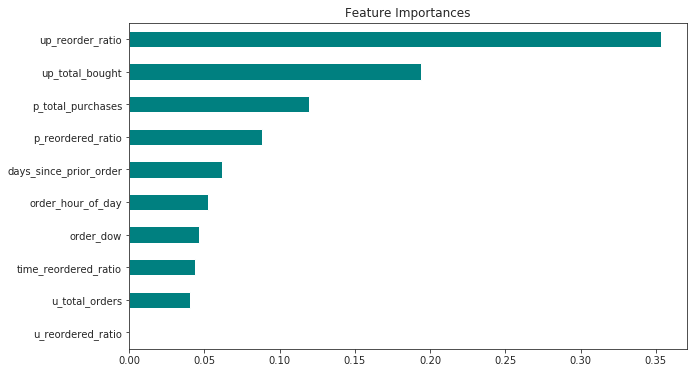

In [0]:
import seaborn as sns
sns.set_style('ticks')

importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 10
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color = 'teal',
          title='Feature Importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')